# r/travel data battle
### by Kairsten Fay, [website linked](http://kairstenfay.github.io)
> This fully reproducible notebook walks through preparing and exploring various aspects of the r/travel survey data. 

## Data cleaning
> Imports and prepared functions

In [210]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import collections

sns.set(style="whitegrid", font_scale=1.5)

def histogram(df, categorical_column, hue=None, title=None, sort_by=None, rotation=0):
    """
    Creates seaborn histograms using categorical data.
    
    Parameters
    ----------
        df : a pandas DataFrame containing the data of interest
        
        categorical_column: a string reprsenting the name of a column on df that will be used as 
                            the x-axis data. Assumed to be categorical.
        title : a string that will be used as the plot's title 
        hue : (optional) a string representing the name of a column on df that will be used for
              grouping within each given categorical column.
        
        sort_by : (optional) a string representing the name of a column on df that will be used to
                  sort df in ascending order. The default argument (None) uses the categorical
                  column for sorting.
    
    """    
    if sort_by:
        df = df.sort_values(sort_by)
    else:
        df = df.sort_values(categorical_column)
        
    f, ax = plt.subplots()
    f.set_size_inches(len(df[categorical_column].unique()) * .9,
                      len(df[categorical_column].unique()) * .9)
    ax = sns.countplot(x=categorical_column, data=df, hue=hue, dodge=True,
                       palette=sns.color_palette("Set2"))
    ax.set_title(title)
    ax.set_xticklabels(labels=df[categorical_column].unique(), rotation=rotation)

    if hue:
        plt.legend(loc='upper right')
    plt.show()

def boxplots(df, numerical_column, categorical_column, title=None):
    """
    Creates seaborn boxplots with stacked underlying data overlaid on each numerical value.
    
    Parameters
    ----------
        df : a pandas DataFrame containing the data of interest
        
        numerical_column: a string reprsenting the name of a column on df that will be used as 
                          the y-axis data. Must be numerical.
        
        categorical_column: a string reprsenting the name of a column on df that will be used as 
                            the x-axis data. Assumed to be categorical.
                            
        title : a string that will be used as the plot's title 
    """
    # Initialize the figure
    f, ax = plt.subplots()
    f.set_size_inches(12, 8)
    sns.despine(bottom=True) 

    # Make box pots
    ax = sns.boxplot(data=df, x=numerical_column, y=categorical_column, linewidth=8,
           fliersize=0, width=.7, palette=sns.color_palette("Set2"))
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))

    # Swarm plot
    ax = sns.swarmplot(data=df, x=numerical_column, y=categorical_column, 
                       palette=sns.color_palette("Set2")).set_title(title)

def violinplot(df, numerical_column, categorical_column, title=None):
    """
    Creates seaborn violinplots with conditional means overlaid on the violins.
    
    Parameters
    ----------
        df : a pandas DataFrame containing the data of interest
        
        numerical_column: a string reprsenting the name of a column on df that will be used as 
                          the y-axis data. Must be numerical.
        
        categorical_column: a string reprsenting the name of a column on df that will be used as 
                            the x-axis data. Assumed to be categorical.
        title : a string that will be used as the plot's title 
    """
    # Initialize the figure
    f, ax = plt.subplots()
    f.set_size_inches(12, 8)
    sns.despine(bottom=True) 
    
    sns.set_context(rc = {'patch.linewidth': 0.0})

    ax = sns.violinplot(data=df, y=categorical_column, x=numerical_column, #scale="area",
                        palette=sns.color_palette("Set2"), linewidth=1.5,
                        inner="quartile")
    
    # Show the mean
    means = df.copy(deep=True).groupby(by=categorical_column, as_index=False).mean()
    sns.pointplot(y=categorical_column, x=numerical_column, 
                  data=means, color="black", join=None,
                  markers="D", scale=1).set_title(title)

    
def gen_sub_df(df, x, y):
    sub_df = df[[x, y]]
    sub_df = sub_df[(sub_df[x].notnull()) & (sub_df[y].notnull())]
    sub_df['count'] = 1
    
    num_groups = len(sub_df[y].unique().tolist())

    sub_df = sub_df.groupby([x, y]).agg('count')
    sub_df = sub_df.unstack(level=1)
    sub_df.columns = sub_df.columns.droplevel()
    return sub_df, num_groups

def donut_charts(df, x, y, title):
    """
    """
    for i in temp[x].unique():
        sub_df, og = gen_sub_df(df[df[x] == i], x, y)

        # Create a circle for the center of the plot
        my_circle=plt.Circle( (0,0), 0.7, color='white')

        plt.pie(sub_df.T, labels=sub_df.columns, colors=sns.color_palette('Set2'))
        p=plt.gcf()
        p.gca().add_artist(my_circle)
        plt.annotate(x + '\n' + sub_df.T.columns[0], (-.2, -.15))
        plt.show()
    
def stacked_barchart(df, x, y, title):
    """
    """
    sub_df, num_groups = gen_sub_df(df, x, y)

    original_columns = sub_df.columns.tolist()

    sub_df['total'] = 0
    for column in original_columns:
        sub_df.loc[sub_df[column].isnull(), column] = 0
        sub_df['total'] += sub_df[column]

    for column in original_columns:
        sub_df[column] /= sub_df['total']
        sub_df[column] *= 100

    for i in range(2, num_groups):
        sub_df['level_' + str(i)] = sub_df[original_columns[2 - i]] + sub_df[original_columns[3 - i]]

    # Then plot bars
    plot_list = []
    plt1 = plt.bar(sub_df.index, sub_df[original_columns[0]], color=sns.color_palette('Set2')[0], 
            edgecolor='white', width=.85)
    plot_list.append(plt1[0])

    counter = 0
    floor = 0
    while counter < num_groups - 1:
        floor += sub_df[original_columns[counter]]
        
        # Plot series
        pltx = plt.bar(sub_df.index, sub_df[original_columns[counter + 1]], 
                              bottom=floor, color=sns.color_palette('Set2')[::-1][counter + 1], 
                              edgecolor='white', width=.85)
        plot_list.append(pltx[0])
        counter += 1
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel('% of responses')
    plt.legend(plot_list, original_columns, title=y,
               bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure)
    
    return

def t_test(a, b, numerical_column):
    """ 
    Perorms a two-tailed t-test for statistical significance and prints results to the console.
    
    Parameters
    ----------
        a : a pandas DataFrame
        b : a pandas DataFrame
        numerical_column : a string depicting a numerical column that exists on both a and b. 
                           Used for comparing statistical significance.
    """
    t, p = stats.ttest_ind(a[numerical_column], b[numerical_column])

    if (t < 0): 
        print("The first argument has a lower value than the second.")
    else:
        print("The first argument has a higher value than the second.")

    print(np.around(p, 4))
    if p < 0.05: 
        print("Statistically significant two-tailed p-value")

In [19]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line.set_label('Label via method')
        line, = ax.plot([1, 2, 3])
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label st

### Read in the data
> Live from from the r/travel Google Sheet.

In [20]:
path_to_csv = r'https://docs.google.com/spreadsheets/d/1vEjRzzTXQFH2XMD_RbJDJ8rPXX12Pwo7UtSRol8xO4Y/export?format=csv'
df = pd.read_csv(path_to_csv)

df = df.rename(columns={'To avoid bot responses from being included, please select "Rome" from the drop-down list': 
                        'bot_check1',
                        'To exclude submissions by bots, please select "a cruise" from the options below.': 
                        'bot_check2'})

# Remove entries that failed the bot test
df = df[(df.bot_check1 == 'Rome') & (df.bot_check2 == 'A cruise')] 
df = df.drop('bot_check1', axis=1)
print(df.shape)
df.head()

(626, 99)


,Timestamp,How old are you?,What gender do you most identify as?,What is your country of primary nationality?,What is your current country of residence?,What is your level of education?,What is your employment status?,"Do you work in the travel industry? (and if so, what sector?)",What is your relationship status?,Do you have a passport?,...,"In three or fewer words, what is your strangest souvenir?","In three of fewer words, what is your favorite/best souvenir?",What is the one item (excluding passport/money/phone/clothes/hygiene) you cannot travel without?,If you could travel to a fictional place which would you choose?,When is your next trip?,What country is your next trip to?,"In 10 words or less, what is your best travel tip?","When deciding on a trip, what is the primary deciding factor?",What would be the most important thing you would like to see change for /r/travel ?,bot_check2
0,19/05/2018 10:32:55,22-29,Male,United States,Germany,Master,Full-time,I do NOT work in the travel industry,Dating,Yes - valid,...,NaN,NaN,earplugs,Tar Valon,0-1 months,Czech Republic,have multiple ways to pay,Cheap transportation,The ban of poptarts,A cruise
2,21/05/2018 09:32:02,30-40,Male,Germany,Germany,Master,Full-time,I do NOT work in the travel industry,Single,Yes - valid,...,NaN,NaN,camera,NaN,0-1 months,United Kingdom,stay flexible,Destination,fewer photos,A cruise
4,21/05/2018 09:45:10,19-21,Female,Malaysia,Malaysia,Bachelor,Unemployed,I do NOT work in the travel industry,Single,Yes - expired,...,Autumn leaves,Coins,Earphones,Elysium,0-1 months,Germany,Watch your belongings.,Destination,nothing,A cruise
5,21/05/2018 09:45:11,30-40,Female,United Kingdom,United Kingdom,Doctorate / PhD,Full-time,I do NOT work in the travel industry,Long-term partnership,Yes - valid,...,Monk biscuits from china. They taste AWFUL.,My first Xmas ornament (the theme I now follow...,a book; a physical copy of some fiction book.,I... don't read that sort of fiction.,2-3 months,Estonia,Walking will take you places cars can not.,Other,More welcoming atmosphere; everyone is a first...,A cruise
8,21/05/2018 10:15:56,17-18,Male,Switzerland,Switzerland,College / Tradeschool,Full-time,I do NOT work in the travel industry,Single,Yes - valid,...,Starbucks Osaka Airport,Japan,There is none,Pandorra (Avatar),2-3 months,United Kingdom,You can have a great trip for cheap,Destination,NaN,A cruise


> Keep only columns with fewer than 25% missingness. For simplicity, assume there was no nonresponse bias and that the population of respondents is representative of all subscribers of r/travel.

In [21]:
sparse_columns = pd.DataFrame(data=df.isna().sum(), columns=['nans'])
sparse_columns['question'] = sparse_columns.index
sparse_columns = sparse_columns[sparse_columns.nans < len(df)/4]

df = df[df.columns[df.columns.isin(sparse_columns.question.unique())]]
df = df.drop('Would you like to take the extended/additional questions? (~5 minutes)', axis=1)

> Rename remaining columns to be shorter and more readable for graphing.

In [22]:
df = df.rename(columns={'When deciding on a trip, what is the primary deciding factor?': 
                        'Primary Trip Deciding Factor',
                        'What would be the most important thing you would like to see change for /r/travel ?':
                        'Important r/travel change',
                        'What is the one item (excluding passport/money/phone/clothes/hygiene) you cannot travel without?':
                        'Item can\'t travel without',
                        'What gender do you most identify as?': 'Gender',
                        'How old are you?': 'Age', 
                        'What is your current country of residence?': 'Country of residence', 
                        'What is your country of primary nationality?': 'Nationality',
                        'What is your level of education?': 'Education',
                        'Do you work in the travel industry? (and if so, what sector?)': 
                        'Travel Industry Sector',
                        'On average, how often do you visit /r/travel ?' : 'Frequency visit r/travel', 
                        'What is your employment status?': 'Employment status',
                        'What is your relationship status?': 'Relationship status',
                        'Do you have a passport?': 'Passport?',
                        'If you could travel to a fictional place which would you choose?': 
                        'Top fictional destination',
                        'On average, how much money do spend on average per year for travel (including all costs)?':
                        'Avg. annual travel expenditure',
                        'On average, how many meals a day do you eat out while traveling?': 
                        'Avg. meals/day eaten out while traveling', 
                        'On average, how many nights do you spend in once place while traveling?': 
                        'Avg. nights/place while traveling',
                        'If you have had a lost bag, where was it lost? (skip or select N/A if you have not lost a bag)':
                        'Lost bag where',
                        'On average, how many trips per year do you take?': 'Avg. trips/year',
                        'On average, how many days per year do you travel?': 'Avg. travel days/year',
                        'On average, how many of your travel days per year are for business? ': 
                        'Avg. travel days/year for business',
                        'On average, how many of your travel days per year are outside the country you live in?': 
                        'Avg. travel days/year international',
                        'Do you usually have travel insurance for your trips?': 'Travel insurance',
                        'Do you have a blog/vlog/social media/etc.specific for your travel?': 
                        'Social media or blog',
                        'How many countries have you traveled to?': 'Num. countries visited',
                        'What is your favorite country you have traveled to?': 'Favorite country',
                        'Please indicate a major currency for use in all further questions': 'Currency',
                        'What motivates you to travel?': 'Why travel', 
                        'On average, how many of your travel days per year are alone?': 
                        'Avg. travel days/year alone', 
                        'If you are working, how many days of vacation (paid time off, not public holidays) do you get each year? (if not, skip or enter 0)': 
                        'Annual PTO',
                        'If you are working, how many years have you held your current job? (if not, skip or enter 0)': 
                        'Years at current job', 
                        'What religious category do you identify best with? (Christianity, Islam, Hinduism, Judaism, Chinese religions (Daoism, etc.), Buddhism, Other, Agnostic, Atheist)': 
                        'Religion',
                        'How many kids do you have?': 'Kids'})
 
travel_mode_question = 'On average, how often do you travel between primary destinations (not day trips or attractions) via each of these modes of transport? (plane, bus, train, boat, bike, car, motorcycle, walk/hike, other) '
travel_mode_response = 'Travel to primary destination by '
for mode in ['Plane', 'Train', 'Bus', 'Boat', 'Bike', 'Car', 'Motorcycle', 'Walk/hike', 'Other']:
               df = df.rename(columns={travel_mode_question + "[" + mode + "]": 
                                       travel_mode_response + mode})

df['Expat'] = False
df.loc[df['Nationality'] != df['Country of residence'], 'Expat'] = True

# Convert currency using exchange rates as of 6-Oct-2018
currency_map = {'US Dollar': 1, 'Euro': 1.15, 'British Pound': 1.31, 'Australian Dollar': .71, 
               'Swiss Franc': 1.01, 'Japanese Yen': .0088}

df['Annual travel expenditure (USD)'] = None
for key in currency_map: 
    df.loc[df['Currency'] == key, 
           'Annual travel expenditure (USD)'] = df['Avg. annual travel expenditure'] * currency_map[key]
    
# Create levels of education for easy ordering
education_map = {'Highschool': 0, 'College / Tradeschool': 1, 'Bachelor': 2, 
                'Master': 3, 'Doctorate / PhD': 4}

df['Education Code'] = None
for key in education_map: 
    df.loc[df['Education'] == key, 'Education Code'] = education_map[key]
df = df.sort_values('Education Code')

# Drop people who traveled more than 365 days in one year
df = df[df['Avg. travel days/year'] <= 365]

> View a sample of some column names.

In [23]:
df.columns.tolist()[0:20]

['Timestamp',
 'Age',
 'Gender',
 'Nationality',
 'Country of residence',
 'Education',
 'Employment status',
 'Travel Industry Sector',
 'Relationship status',
 'Passport?',
 'Avg. trips/year',
 'Avg. travel days/year',
 'Avg. travel days/year for business',
 'Avg. travel days/year international',
 'Currency',
 'Frequency visit r/travel',
 'Travel to primary destination by Plane',
 'Travel to primary destination by Bus',
 'Travel to primary destination by Train',
 'Travel to primary destination by Boat']

## Data exploration

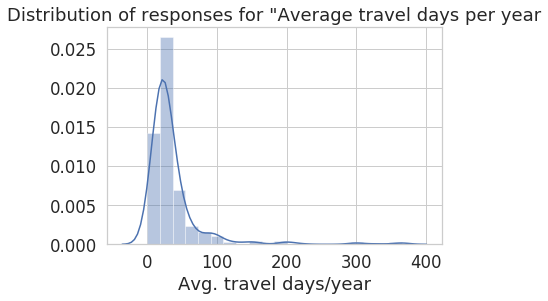

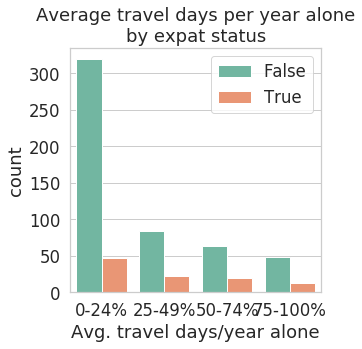

In [24]:
sub_df = df[df["Avg. travel days/year"].notnull()]
ax = sns.distplot(sub_df["Avg. travel days/year"], bins=20
                 ).set_title("Distribution of responses for \"Average travel days per year")
plt.show()

histogram(df, 'Avg. travel days/year alone', hue='Expat', title="Average travel days per year alone\nby expat status")

## How does age affect subscribers of r/travel?

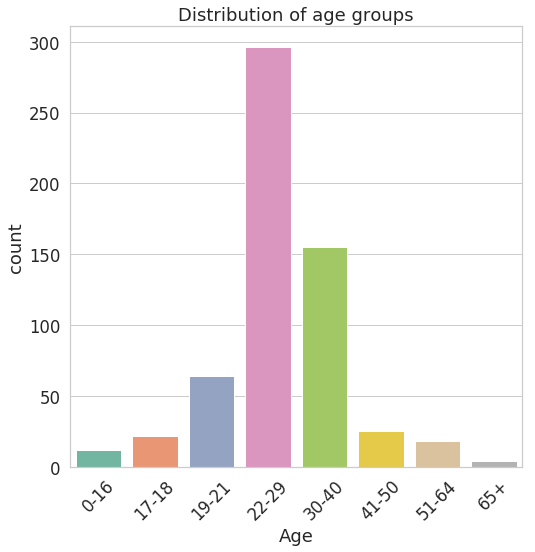

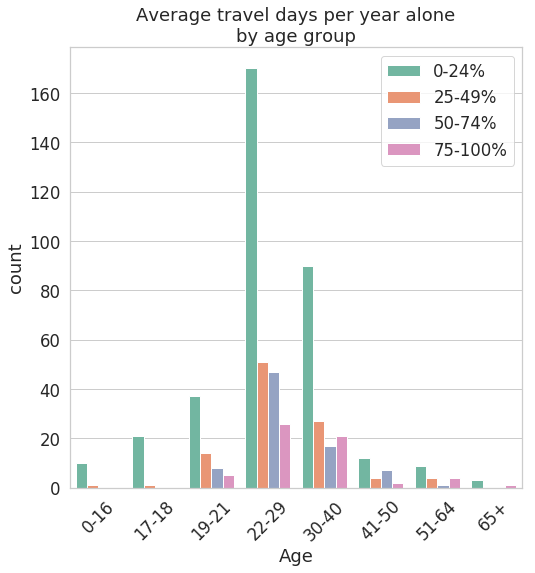

In [25]:
histogram(df, 'Age', title="Distribution of age groups", rotation=45)
histogram(df, 'Age', hue='Avg. travel days/year alone', 
          title="Average travel days per year alone\nby age group", rotation=45)

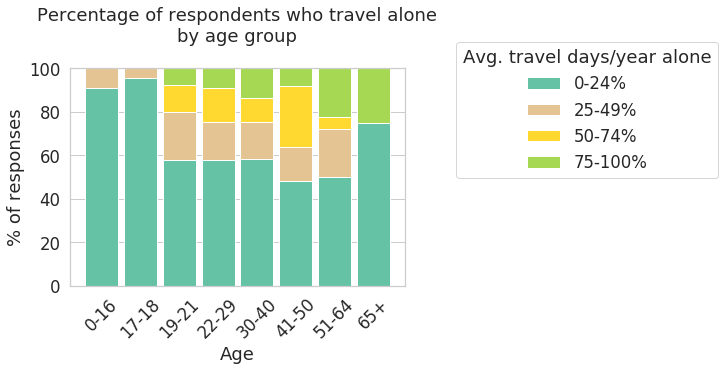

In [154]:
stacked_barchart(df, 'Age', 'Avg. travel days/year alone', 
                 'Percentage of respondents who travel alone\nby age group\n')

In [ ]:
df = df.sort_values('Age')
temp = df[df.Age.notnull()]

f, ax = plt.subplots()
f.set_size_inches(12, 18)
    
# plt.tight_layout()
index = 1
num_cols = 3
num_rows = num_cols + len(temp['Age'].unique()) % 3
plt.title('alone time')
plt.tight_layout()
plt.subplot(num_rows, num_cols, 1)

for i in temp['Age'].unique():
    sub_df, og = gen_sub_df(temp[temp['Age'] == i], 'Age', 'Avg. travel days/year alone')

    # Create a circle for the center of the plot
    my_circle=plt.Circle( (0,0), 0.7, color='white')

    plt.pie(sub_df.T, labels=sub_df.columns, colors=sns.color_palette('Set2'))
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.annotate('Ages\n' + sub_df.T.columns[0], (-.2, -.15))
    
    plt.subplot(num_rows, num_cols, index + 1)
    index += 1
plt.show()

In [268]:
num_rows

2

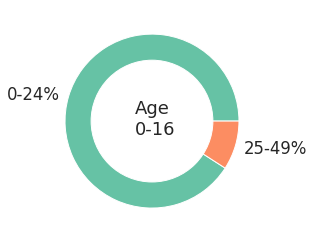

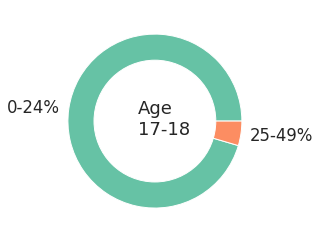

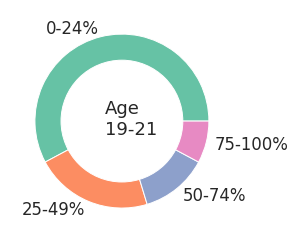

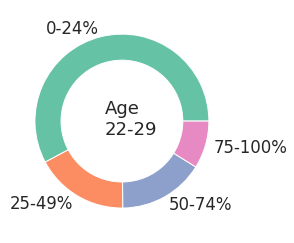

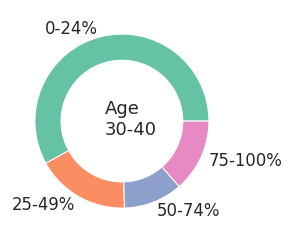

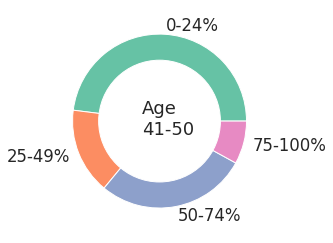

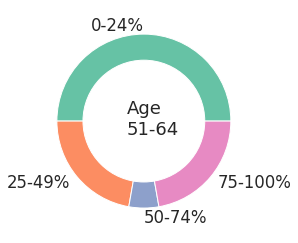

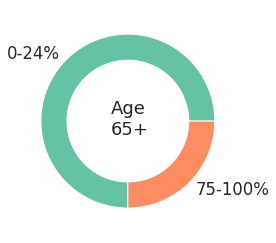

In [212]:
df = df.sort_values('Age')
temp = df[df.Age.notnull()]

donut_charts(df, 'Age', 'Avg. travel days/year alone', 'Title')

In [11]:
# create data
size_of_groups=[12,11,3,30]
 
x = 'smoker'
y = 'time'
sub_df = tips[[x, y]]
sub_df = sub_df[(sub_df[x].notnull()) & (sub_df[y].notnull())]
sub_df['count'] = 1
num_groups = len(sub_df[y].unique().tolist())

sub_df = sub_df.groupby([x, y], as_index=False).agg('count')
# sub_df = sub_df.unstack(level=1)


# Set up axes
g = sns.FacetGrid(sub_df, col="time", row="smoker")
# g = g.map(plt.hist, "total_bill")

# Create a pieplot
plt.pie(sub_df['count'])
#plt.show()


 
plt.show()

NameError: name 'tips' is not defined

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()

# First plot
fig.add_subplot(1,2,1)
plt.axis('equal') 
plt.pie(range(0,5))
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Plot 1")
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')


# Second plot
fig.add_subplot(1,2,2)
plt.axis('equal') 
plt.pie(range(0,10))
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title("Plot 2")
# add a circle at the center
my_circle=plt.Circle( (0,0), 0.7, color='white')


plt.show()

In [ ]:
x = 'smoker'
y = 'time'
sub_df = tips[[x, y]]
sub_df = sub_df[(sub_df[x].notnull()) & (sub_df[y].notnull())]
sub_df['count'] = 1
num_groups = len(sub_df[y].unique().tolist())

sub_df = sub_df.groupby([y, x], as_index=False).agg('count')
#sub_df = sub_df.unstack(level=-1)
#sub_df.columns = sub_df.columns.droplevel()

sub_df.tail()

In [ ]:
sub_df.columns

In [ ]:
tips = sns.load_dataset("tips")
tips.head()

### Travel days per year

In [ ]:
numerical_column = 'Avg. travel days/year'
categorical_column = 'Age'
df = df.sort_values(categorical_column)

# Outlier
sub_df = df[df[numerical_column] <= 200]
scatterplot(sub_df, numerical_column, categorical_column, title='Average travel days per year\nby age group')
violinplot(sub_df, numerical_column, categorical_column, title='Average travel days per year\nby age group')

## How does relationship status affect subscribers of r/travel? 

In [ ]:
histogram(df, 'Relationship status')

df['Proportion of travel alone'] = None
alone_map = {'0-24%': 0, '25-49%': 1, '50-74%': 2, '75-100%': 3}

for key in alone_map:
    df.loc[df['Avg. travel days/year alone'] == key, 'Proportion of travel alone'] = alone_map[key]

histogram(df, 'Avg. travel days/year alone', 'Relationship status', 
          title='Average travel days per year alone\nby relationship status')

> Nearly all respondents who travel alone 75-100% of the time were single. Single people were more likely to travel alone in general. Meanwhile, people in a long-term partnership were least likely to travel alone. 

In [ ]:
a = df[(df['Relationship status'] == 'Long-term partnership') & (df['Avg. travel days/year alone'].notnull())]
b = df[(df['Relationship status'] == 'Dating') &
               (df['Avg. travel days/year alone'].notnull())]

t_test(a, b, 'Proportion of travel alone')

> Annual travel days

In [ ]:
numerical_column = 'Avg. travel days/year'
categorical_column = 'Relationship status'
df = df.sort_values(categorical_column)

# Outlier
sub_df = df[df[numerical_column] <= 200]
sub_df.loc[sub_df[categorical_column] == 'Long-term partnership', categorical_column] = 'Long-term\npartnership'
scatterplot(sub_df, numerical_column, categorical_column)
# ax.set_ylim(0, 150)

violinplot(sub_df, numerical_column, categorical_column)

> People who are in long-term relationships take more travel days/year than people who are single.

In [ ]:
a = df[(df['Relationship status'] == 'Single') & (df['Avg. travel days/year'].notnull())]
b = df[(df['Relationship status'] == 'Long-term partnership') &
               (df['Avg. travel days/year'].notnull())]
t_test(a, b, 'Avg. travel days/year')

## How does education level affect subscribers of r/travel?

In [ ]:
histogram(df, 'Education', sort_by='Education Code')
scatterplot(df, 'Avg. travel days/year', 'Education')
violinplot(df, 'Avg. travel days/year', 'Education')

> People with advanced degrees (Masters or Doctorate/PhD) took significantly more vacation time than people with only a high school education.
People with Masters degrees also took more vacation time than people with a college/tradeschool education.

In [ ]:
a = df[(df['Education'] == 'Master') & (df['Avg. travel days/year'].notnull())]
b = df[(df['Education'] == 'Doctorate / PhD') &
               (df['Avg. travel days/year'].notnull())]

t_test(a, b, 'Avg. travel days/year')

In [ ]:
df = df.sort_values('Education Code')

# Outlier
sub_df = df[df['Avg. travel days/year for business'] < 100]
scatterplot(sub_df, 'Avg. travel days/year for business', 'Education')
violinplot(sub_df, 'Avg. travel days/year for business', 'Education')

> High school diploma holders had the fewest travel days per year through business travel.

In [ ]:
a = df[(df['Education'] == 'Bachelor') & (df['Avg. travel days/year for business'].notnull())]
b = df[(df['Education'] == 'Doctorate / PhD') &
               (df['Avg. travel days/year for business'].notnull())]
t_test(a, b, 'Avg. travel days/year for business')

### Travel Expenditure

In [ ]:
numeric_column = 'Annual travel expenditure (USD)'

# Outlier a few points
sub_df = df[df[numeric_column] <= 120000].sort_values('Education Code')
print(len(df))
print(len(sub_df))
sub_df[numeric_column] = sub_df[numeric_column].astype('int')

scatterplot(sub_df, numeric_column, 'Education')
violinplot(sub_df, 'Annual travel expenditure (USD)', 'Education')

> Doctorate/PhD holders spent more on vacation than all other levels of education, despite having the same number of travel days/year (other than High school diploma holders)
> All other levels of education spent the same.

In [ ]:
numerical_column = 'Annual travel expenditure (USD)'

a = df[(df['Education'] == 'Highschool') & (df[numerical_column].notnull())]
b = df[(df['Education'] == 'College / Tradeschool') &
               (df[numerical_column].notnull())]
t_test(a, b, numerical_column)

## Gender

In [ ]:
histogram(df, "Gender")
scatterplot(df, 'Avg. travel days/year', 'Gender')
violinplot(df, 'Avg. travel days/year', 'Gender')

## Employment status

In [ ]:
histogram(df, "Employment status")
scatterplot(df, 'Avg. travel days/year', 'Employment status')
violinplot(df, 'Avg. travel days/year', 'Employment status')

In [ ]:
# Duh!
# scatterplot(df, 'Avg. travel days/year for business', 'Employment status')
# violinplot(df, 'Avg. travel days/year for business', 'Employment status')

In [ ]:
sub_df = df[df['Annual travel expenditure (USD)'].notnull()]
sub_df['Annual travel expenditure (USD)'] = sub_df['Annual travel expenditure (USD)'].astype('int')

# Outlier
sub_df = sub_df[sub_df['Annual travel expenditure (USD)'] <= 120000]

scatterplot(sub_df, 'Annual travel expenditure (USD)', 'Employment status')
violinplot(sub_df, 'Annual travel expenditure (USD)', 'Employment status')

## How is r/travel visit frequency correlated with travel? 

In [ ]:
sns.set(style="white")

df.loc[df['Frequency visit r/travel'] == 
       'Only when you notice something interesting (e.g. from /r/popular)', 
      'Frequency visit r/travel'] = 'After a top post'
df.loc[df['Frequency visit r/travel'] == 
       'Only when planning a trip', 'Frequency visit r/travel'] = 'When trip planning'
sub_df = df[df['Frequency visit r/travel'].notnull()]

histogram(sub_df, "Frequency visit r/travel")

sub_df = sub_df[sub_df['Avg. travel days/year'].notnull()]
sub_df['Avg. travel days/year'] = sub_df['Avg. travel days/year'].astype('int')

scatterplot(sub_df, 'Avg. travel days/year', 'Frequency visit r/travel')
violinplot(sub_df, 'Avg. travel days/year', 'Frequency visit r/travel')

> People who visited r/travel traveled more days/year than did people who only visited r/travel monthly or when trip planning.

In [ ]:
numerical_column = 'Avg. travel days/year'

a = df[(df['Frequency visit r/travel'] == 'Daily') & (df[numerical_column].notnull())]
b = df[(df['Frequency visit r/travel'] == 'After a top post') &
               (df[numerical_column].notnull())]
t_test(a, b, numerical_column)

In [ ]:
numeric_column = 'Annual travel expenditure (USD)'

# Outlier a few points
sub_df = df[df[numeric_column] <= 120000].sort_values('Frequency visit r/travel')
print(len(df))
print(len(sub_df))
sub_df[numeric_column] = sub_df[numeric_column].astype('int')

scatterplot(sub_df, numeric_column, 'Frequency visit r/travel')
violinplot(sub_df, numeric_column, 'Frequency visit r/travel')

> People who visited r/travel only when trip planning spent less per year on vacation than did those who visited r/travel daily, weekly, or monthly.

In [ ]:
numerical_column = 'Annual travel expenditure (USD)'

a = df[(df['Frequency visit r/travel'] == 'When trip planning') & (df[numerical_column].notnull())]
b = df[(df['Frequency visit r/travel'] == 'Weekly') &
               (df[numerical_column].notnull())]
t_test(a, b, numerical_column)

## How does having kids affect travel? 

In [ ]:
sns.set(style="white")
df = df.sort_values('Kids')
ax = sns.countplot(x="Kids", data=df)
plt.show()

In [ ]:
df.head()

In [ ]:
numeric_column = 'Avg. travel days/year'
categorical_column = 'Kids'

# Combine kids due to low sample size 
if df[categorical_column].dtype == 'object':
    df.loc[(df[categorical_column] == '3') | 
    (df[categorical_column] == '4') | 
    (df[categorical_column] == '5+'), categorical_column] = '3'
df[categorical_column] = df[categorical_column].astype('float')
print(df[categorical_column].value_counts())
print(df[numeric_column].head())
scatterplot(df, numeric_column, categorical_column)
# violinplot(df, numeric_column, categorical_column)

In [ ]:
#df['Years at current job'].value_counts()
#sub_df = df[df['Years at current job'] > 0]
g = sns.relplot(x="Kids", y="Avg. travel days/year", #size="size",
                palette=["b", "r"], sizes=(10, 100), #hue="time", col="time",
                data=sub_df)

In [ ]:
df['Years at current job'].value_counts()
sub_df = df[df['Years at current job'] > 0]
g = sns.relplot(x="Years at current job", y="Avg. travel days/year", #size="size",
                palette=["b", "r"], sizes=(10, 100), #hue="time", col="time",
                data=sub_df)

In [ ]:
sub_df.loc[sub_df['Annual PTO'] > 365, 'Annual PTO'] = 365
g = sns.relplot(x="Annual PTO", y="Avg. travel days/year", #size="size",
                palette=["b", "r"], sizes=(10, 100), #hue="time", col="time",
                data=sub_df)

## How does religion affect travel?

In [ ]:
numeric_column = 'Annual travel expenditure (USD)'

# Outlier a few points
sub_df = df[df[numeric_column] <= 120000].sort_values('Religion')
print(len(df))
print(len(sub_df))
sub_df[numeric_column] = sub_df[numeric_column].astype('int')

scatterplot(sub_df, numeric_column, 'Religion')
violinplot(sub_df, numeric_column, 'Religion')

# How does planned travel time affect r/travel usage?